In [6]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
from PIL import Image

if not os.path.exists('temp'):
    os.makedirs('temp')

# set random seed for reproducibility
np.random.seed(0)

# Define a function to simulate an odor plume
def simulate_odor_plume(
            num_steps: int, # number of steps to simulate
            dt: float, # time step
            grid_size: tuple, # size of the grid
            source_location: tuple, # location of the odor source
            source_strength: np.ndarray, # strength of the odor source time series
            source_radius: np.ndarray, # radius of the odor source time series
            release_rate: float, # odor release rate
            wind_speed: np.ndarray, # wind speed time series
            wind_direction: np.ndarray, # wind direction time series 
            diffusion_coefficient: float, # diffusion coefficient
        ) -> np.ndarray:
    
    # Extract grid size
    grid_width, grid_height = grid_size

    # Initialize concentration grid and concentration time series
    concentration = np.zeros(grid_size)
    concentration_time_series = np.zeros((num_steps, grid_size[0], grid_size[1]))
    
    # Initialize source at the center of the grid
    source_y, source_x = source_location

    
    for step in tqdm(range(num_steps)):
        # Calculate wind velocity components
        wind_velocity_x = wind_speed[step] * np.cos(wind_direction[step]) * dt
        wind_velocity_y = wind_speed[step] * np.sin(wind_direction[step]) * dt
        
        # Compute advection using 2d shift
        concentration = nd.shift(concentration, (wind_velocity_x, wind_velocity_y), order=0)
        
        # Release odor bursts from the source
        poisson = np.random.poisson(release_rate * dt)
        if poisson > 0:
            # create a 2D Gaussian centered at the source with the specified radius
            increase_x,increase_y = np.meshgrid(np.arange(grid_height), np.arange(grid_width))
            increase = np.exp(-((increase_x - source_x)**2 + (increase_y - source_y)**2) / (2*source_radius[step]**2))
            increase = increase / np.sum(increase)
            # add the Gaussian to the concentration grid
            concentration += source_strength[step] * increase * poisson
        
        # Compute diffusion using 2D convolution with Gaussian filter
        concentration = nd.gaussian_filter(concentration, diffusion_coefficient)
        
        # Store concentration in concentration time series
        concentration_time_series[step] = concentration
    
    return concentration_time_series

# Example usage
dt = 0.1
num_steps = 1000
grid_size = (500, 50)
wind_speed = np.random.normal(10, 0., num_steps)
wind_direction = np.random.normal(0., 0, num_steps)
diffusion_coefficient = 0.5
release_rate = 20
source_location = (10, 25)
source_strength = np.random.normal(1, 0.0, num_steps)
source_radius = np.random.normal(1, 0.0, num_steps)

time_series = simulate_odor_plume(
    num_steps=num_steps,
    dt=dt,
    grid_size=grid_size,
    source_location=source_location,
    source_strength=source_strength,
    source_radius=source_radius,
    release_rate=release_rate,
    wind_speed=wind_speed,
    wind_direction=wind_direction,
    diffusion_coefficient=diffusion_coefficient,
)


100%|██████████| 1000/1000 [00:01<00:00, 717.82it/s]


In [7]:
# discretize (if needed)
digitize = None
space = 'linear' # 'log' or 'linear' or 'geom'

if digitize is not None:
    if space == 'log':
        bins = np.max(time_series)+ 1e-5 - np.logspace(np.log10(np.max(time_series)),-5, digitize)
    elif space == 'linear':
        bins = np.linspace(0, np.max(time_series), digitize)
    elif space == 'geom':
        bins = np.max(time_series)+ 1e-5 - np.geomspace(np.max(time_series), 1e-5, digitize)
    ts = np.digitize(time_series, bins)
else:
    ts = time_series

# convert time series to GIF using PIL
frames = []
maxx = np.max(ts)
for i in tqdm(range(num_steps)):
    frame = Image.fromarray(np.uint8(ts[i]/maxx * 255).T)
    frames.append(frame)
frames[0].save('odor_plume.gif', format='GIF', append_images=frames[1:], save_all=True, fps=30, loop=0)

100%|██████████| 1000/1000 [00:00<00:00, 4320.47it/s]


100%|█████████▉| 996/1000 [00:34<00:00, 34.28it/s]

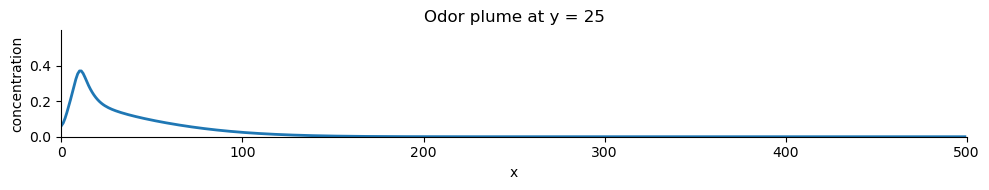

100%|█████████▉| 996/1000 [00:45<00:00, 34.28it/s]

In [3]:
# make an animation using matplotlib of the odor plume at y = source_location[1]
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
ax.set_xlim(0, grid_size[0])
ax.set_ylim(0, np.max(ts))
ax.set_xlabel('x')
ax.set_ylabel('concentration')
ax.set_title('Odor plume at y = {}'.format(source_location[1]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
fig.tight_layout()

line, = ax.plot([], [], lw=2)
def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    line.set_data(np.arange(grid_size[0]), ts[i, :, source_location[1]])
    return (line,)
from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate, init_func=init, frames=tqdm(range(num_steps), file=sys.stdout), interval=20, blit=True)
anim.save('odor_conc.gif', fps=30)

In [22]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
from PIL import Image

if not os.path.exists('temp'):
    os.makedirs('temp')

# set random seed for reproducibility
np.random.seed(0)

# Define a function to simulate an odor plume
def simulate_odor_plume(
            num_steps: int, # number of steps to simulate
            dt: float, # time step
            grid_size: tuple, # size of the grid
            source_location: tuple, # location of the odor source
            source_init_radius: float, # initial radius of the odor source
            source_peak_concentration: float, # initial concentration of the odor source
            puff_release_rate: float, # odor release rate
            init_num_puffs: int, # initial number of puffs
            max_puffs: int, # maximum number of puffs
            diffusion_coefficient: float, # diffusion coefficient
            brownian_noise_scale: float, # scale of the Brownian noise
            wind_speed: np.ndarray, # wind speed time series
            wind_direction: np.ndarray, # wind direction time series 
        ) -> np.ndarray:
    
    # Extract grid size
    grid_width, grid_height = grid_size

    # Initialize concentration grid and concentration time series
    concentration_time_series = np.zeros((num_steps, grid_size[0], grid_size[1]))

    # Set source location
    source_y, source_x = source_location

    # initialize puffs
    puffs = np.array([[source_x, source_y, source_init_radius, source_peak_concentration]]*init_num_puffs, dtype=np.float32)
    n_puffs = init_num_puffs

    
    for step in tqdm(range(num_steps)):

        # Release odor puffs from the source
        poisson = np.random.poisson(puff_release_rate * dt)
        if poisson > 0:
            for _ in range(min(poisson, max_puffs - n_puffs)):
                puffs = np.append(puffs, np.array([[source_x, source_y, source_init_radius, source_peak_concentration]],dtype=np.float32) , axis=0)
                n_puffs += 1
            
        # Calculate wind velocity components
        wind_velocity_x = wind_speed[step] * np.cos(wind_direction[step]) * dt
        wind_velocity_y = wind_speed[step] * np.sin(wind_direction[step]) * dt

        # Add Brownian noise to the velocity components
        wind_velocity_x += np.random.normal(0, brownian_noise_scale)
        wind_velocity_y += np.random.normal(0, brownian_noise_scale)

        # update puff positions
        puffs[:, 0] += wind_velocity_x
        puffs[:, 1] += wind_velocity_y

        # update puff radii
        puffs[:, 2] += diffusion_coefficient * dt

        # compute concentration at each grid point
        for n,puff in enumerate(puffs):
            x, y, r, s = puff
            x, y = int(x), int(y)
            if x >= 0 and x < grid_width and y >= 0 and y < grid_height:
                x_grid, y_grid = np.meshgrid(np.arange(grid_height), np.arange(grid_width))
                gaussian = np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2*r**2))
                gaussian = gaussian / np.sum(gaussian)
                concentration_time_series[step] += s * gaussian
            else:
                puffs = np.delete(puffs, n, 0)
                n_puffs -= 1
    
    return concentration_time_series

# Example usage
dt = 0.1
sim_duration = 60
num_steps = int(sim_duration / dt)

grid_size = (500, 50)
source_location = (10, 25)
source_init_radius = 1
source_peak_concentration = 1
puff_release_rate = 10
init_num_puffs = 1
max_puffs = 100
diffusion_coefficient = 0.1
brownian_noise_scale = 0.1

wind_speed = np.ones(num_steps) * 1
wind_direction = np.ones(num_steps) * 0.0



time_series = simulate_odor_plume(
    num_steps=num_steps,
    dt=dt,
    grid_size=grid_size,
    source_location=source_location,
    source_init_radius=source_init_radius,
    source_peak_concentration=source_peak_concentration,
    puff_release_rate=puff_release_rate,
    init_num_puffs=init_num_puffs,
    max_puffs=max_puffs,
    diffusion_coefficient=diffusion_coefficient,
    brownian_noise_scale=brownian_noise_scale,
    wind_speed=wind_speed,
    wind_direction=wind_direction,
)


  2%|▏         | 11/600 [00:00<00:05, 102.34it/s]

100%|██████████| 600/600 [00:19<00:00, 31.43it/s]


In [23]:
# discretize (if needed)
digitize = None
space = 'linear' # 'log' or 'linear' or 'geom'

if digitize is not None:
    if space == 'log':
        bins = np.max(time_series)+ 1e-5 - np.logspace(np.log10(np.max(time_series)),-5, digitize)
    elif space == 'linear':
        bins = np.linspace(0, np.max(time_series), digitize)
    elif space == 'geom':
        bins = np.max(time_series)+ 1e-5 - np.geomspace(np.max(time_series), 1e-5, digitize)
    ts = np.digitize(time_series, bins)
else:
    ts = time_series

# convert time series to GIF using PIL
frames = []
maxx = np.max(ts)
for i in tqdm(range(num_steps)):
    frame = Image.fromarray(np.uint8(ts[i]/maxx * 255).T)
    frames.append(frame)
frames[0].save('odor_plume.gif', format='GIF', append_images=frames[1:], save_all=True, fps=30, loop=0)

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:00<00:00, 2908.85it/s]
